In [1]:
#Import external functions
from image_processing import *
from utils import *
from custom_models import *

from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [2]:
# Load images for training
path_to_images = '/data_generator/UCF-101-frames'
weight_file_path = 'saved_models/pretrained_model.h5'

target_size = (240,320)
batch_size = 32


train_folder = path_to_images + '/train'
train_datagen = ImageDataGenerator(rotation_range=10,
                                   preprocessing_function=preprocess_input,
                                   rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.33)
training_batches2 = train_datagen.flow_from_directory(train_folder,
                                                     target_size=target_size,
                                                     batch_size=batch_size,
                                                     interpolation='bicubic',
                                                     subset='training')
training_batches = crop_generator(training_batches2, crop_width, crop_height, random=True)

validation_batches2 = train_datagen.flow_from_directory(train_folder,
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       interpolation='bicubic',
                                                       subset='validation')
validation_batches = crop_generator(validation_batches2, crop_width, crop_height, random=True)

test_folder = path_to_images + '/test'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1./255)
testing_batches2 = test_datagen.flow_from_directory(test_folder,
                                                   target_size=target_size,
                                                   batch_size=batch_size,
                                                   interpolation='bicubic')
testing_batches = crop_generator(testing_batches2, crop_width, crop_height, random=False)

classes_dictionary = {}
for cls, idx in training_batches2.class_indices.items():
    classes_dictionary[idx] = cls

Found 956573 images belonging to 101 classes.
Found 471071 images belonging to 101 classes.
Found 540949 images belonging to 101 classes.


In [3]:
# Single frame model definition
input_shape = (crop_height,crop_width,3)

#SGD Optimizer Parameters
base_lr = 0.001
momentum = 0.9

#Step-based LearningRate Parameters
epochs = 1000#120 # 450000
gamma = 0.1
stepsize = 400#40 # 100000

In [4]:
# Load pretrained (ILSVRC2012) model weights
pm_dict = get_h5_weights(weight_file_path)

In [5]:
model = CaffeDonahueFunctional(input_shape, num_labels)

# Load Pretrained weights into model
model = load_pretrained_weights(model, pm_dict)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 111, 111, 96) 14208       input_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 55, 55, 96)   0           conv1[0][0]                      
__________________________________________________________________________________________________
norm1 (LRN2D)                   (None, 55, 55, 96)   0           pool1[0][0]                      
__________________________________________________________________________________________________
lambda_1 (

In [7]:
def freeze_all_but_top(model):
    # Used to train just the top layers of the model.
    for layer in model.layers[:23]:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def freeze_all_but_mid_and_top(model):
    # After we fine-tune the dense layers, train deeper.
    for layer in model.layers[:1]:
        layer.trainable = False
    for layer in model.layers[1:]:
        layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate 0.001
    model = model_compile(model, base_lr, momentum)

    return model

In [8]:
def train_model(model, nb_epoch, train_generator, validation_generator , callbacks=[]):
    history = model.fit_generator(train_generator,
                                  steps_per_epoch=100,
                                  validation_data=validation_generator,
                                  validation_steps=10,
                                  epochs=nb_epoch,
                                  callbacks=callbacks)

    return history,model

In [9]:
model = freeze_all_but_top(model)
history1, model = train_model(model, 10, training_batches, validation_batches)

Epoch 1/10
100/100 [==============================] - 39s 389ms/step - loss: 5.6903 - acc: 0.0228 - val_loss: 5.2255 - val_acc: 0.0281
Epoch 2/10
100/100 [==============================] - 35s 348ms/step - loss: 5.2124 - acc: 0.0422 - val_loss: 5.1325 - val_acc: 0.0594
Epoch 3/10
100/100 [==============================] - 35s 349ms/step - loss: 5.0946 - acc: 0.0650 - val_loss: 4.9515 - val_acc: 0.0750
Epoch 4/10
100/100 [==============================] - 35s 348ms/step - loss: 5.0081 - acc: 0.0991 - val_loss: 4.9839 - val_acc: 0.0719
Epoch 5/10
100/100 [==============================] - 35s 349ms/step - loss: 4.9728 - acc: 0.1091 - val_loss: 5.3462 - val_acc: 0.0906
Epoch 6/10
100/100 [==============================] - 35s 350ms/step - loss: 5.0320 - acc: 0.1225 - val_loss: 5.2060 - val_acc: 0.0750
Epoch 7/10
100/100 [==============================] - 35s 350ms/step - loss: 5.0541 - acc: 0.1319 - val_loss: 5.2937 - val_acc: 0.0938
Epoch 8/10
100/100 [==============================] - 3

In [10]:
#### STEP-BASED DECAY
# To Keras ston SGD apo mono tou kanei time-based decay
# Protimoume Step decay, giati emfanizei kalutero convergence
# Isws 8a mporousa na dokimasw kai Adaptive Learning
#
# Possible solution : https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
# Possible solution : https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
####
def step_decay(epoch):
    initial_lrate = base_lr
    drop = gamma
    epochs_drop = stepsize
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [11]:
filepath = 'saved_models/caffenet_single_rgb.hdf5'
checkpointer = ModelCheckpoint(filepath=filepath,verbose=1,save_best_only=True)
# early_stopper = EarlyStopping(patience=30)
# tensorboard = TensorBoard(log_dir='logs')
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay,verbose=1)


model = freeze_all_but_mid_and_top(model)
history, model = train_model(model, epochs, training_batches, validation_batches,
                             [loss_history,lrate, checkpointer,])

Epoch 1/1000

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 38s 379ms/step - loss: 5.1016 - acc: 0.1844 - top_k_categorical_accuracy: 0.4525 - val_loss: 4.9101 - val_acc: 0.2250 - val_top_k_categorical_accuracy: 0.4719

Epoch 00001: val_loss improved from inf to 4.91015, saving model to saved_models/caffenet_finetuning/caffenet_single_rgb.hdf5
Epoch 2/1000

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 36s 359ms/step - loss: 4.8154 - acc: 0.2191 - top_k_categorical_accuracy: 0.4937 - val_loss: 5.0991 - val_acc: 0.1781 - val_top_k_categorical_accuracy: 0.4375

Epoch 00002: val_loss did not improve from 4.91015
Epoch 3/1000

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 350ms/step - loss: 4.6793 - acc: 0.2563 - top_k_categorical_accuracy: 0.5353 - val_loss: 5.0130 - val_acc: 0.1844 - val_top_k_c


Epoch 00023: val_loss did not improve from 4.14542
Epoch 24/1000

Epoch 00024: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 36s 356ms/step - loss: 3.4896 - acc: 0.4584 - top_k_categorical_accuracy: 0.7606 - val_loss: 4.3533 - val_acc: 0.3156 - val_top_k_categorical_accuracy: 0.5844

Epoch 00024: val_loss did not improve from 4.14542
Epoch 25/1000

Epoch 00025: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 36s 365ms/step - loss: 3.4232 - acc: 0.4641 - top_k_categorical_accuracy: 0.7694 - val_loss: 4.3324 - val_acc: 0.3125 - val_top_k_categorical_accuracy: 0.6031

Epoch 00025: val_loss did not improve from 4.14542
Epoch 26/1000

Epoch 00026: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 36s 358ms/step - loss: 3.4502 - acc: 0.4609 - top_k_categorical_accuracy: 0.7659 - val_loss: 4.1126 - val_acc: 0.3469 - val_top_k_categorical_accuracy:


Epoch 00046: val_loss did not improve from 3.73986
Epoch 47/1000

Epoch 00047: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 351ms/step - loss: 2.7101 - acc: 0.6072 - top_k_categorical_accuracy: 0.8691 - val_loss: 3.9518 - val_acc: 0.3937 - val_top_k_categorical_accuracy: 0.6656

Epoch 00047: val_loss did not improve from 3.73986
Epoch 48/1000

Epoch 00048: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 37s 366ms/step - loss: 2.6539 - acc: 0.6203 - top_k_categorical_accuracy: 0.8787 - val_loss: 3.7671 - val_acc: 0.4125 - val_top_k_categorical_accuracy: 0.6531

Epoch 00048: val_loss did not improve from 3.73986
Epoch 49/1000

Epoch 00049: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 349ms/step - loss: 2.6237 - acc: 0.6328 - top_k_categorical_accuracy: 0.8831 - val_loss: 4.0225 - val_acc: 0.3969 - val_top_k_categorical_accuracy:


Epoch 00070: val_loss did not improve from 3.68672
Epoch 71/1000

Epoch 00071: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 351ms/step - loss: 2.1591 - acc: 0.7341 - top_k_categorical_accuracy: 0.9328 - val_loss: 3.9332 - val_acc: 0.3969 - val_top_k_categorical_accuracy: 0.6813

Epoch 00071: val_loss did not improve from 3.68672
Epoch 72/1000

Epoch 00072: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 351ms/step - loss: 2.1401 - acc: 0.7372 - top_k_categorical_accuracy: 0.9306 - val_loss: 4.0587 - val_acc: 0.4188 - val_top_k_categorical_accuracy: 0.6750

Epoch 00072: val_loss did not improve from 3.68672
Epoch 73/1000

Epoch 00073: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 352ms/step - loss: 2.1493 - acc: 0.7325 - top_k_categorical_accuracy: 0.9291 - val_loss: 3.9805 - val_acc: 0.4188 - val_top_k_categorical_accuracy:

100/100 [==============================] - 35s 352ms/step - loss: 1.7977 - acc: 0.8128 - top_k_categorical_accuracy: 0.9622 - val_loss: 3.8732 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.6844

Epoch 00095: val_loss did not improve from 3.68672
Epoch 96/1000

Epoch 00096: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 352ms/step - loss: 1.7511 - acc: 0.8228 - top_k_categorical_accuracy: 0.9647 - val_loss: 3.8903 - val_acc: 0.4250 - val_top_k_categorical_accuracy: 0.7031

Epoch 00096: val_loss did not improve from 3.68672
Epoch 97/1000

Epoch 00097: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 352ms/step - loss: 1.7815 - acc: 0.8219 - top_k_categorical_accuracy: 0.9572 - val_loss: 3.6708 - val_acc: 0.4094 - val_top_k_categorical_accuracy: 0.7063

Epoch 00097: val_loss improved from 3.68672 to 3.67078, saving model to saved_models/caffenet_finetuning/caffenet_single_rgb.

100/100 [==============================] - 35s 351ms/step - loss: 1.4231 - acc: 0.8906 - top_k_categorical_accuracy: 0.9825 - val_loss: 4.1501 - val_acc: 0.4031 - val_top_k_categorical_accuracy: 0.6625

Epoch 00143: val_loss did not improve from 3.66764
Epoch 144/1000

Epoch 00144: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 353ms/step - loss: 1.4077 - acc: 0.8925 - top_k_categorical_accuracy: 0.9819 - val_loss: 4.1019 - val_acc: 0.4219 - val_top_k_categorical_accuracy: 0.6781

Epoch 00144: val_loss did not improve from 3.66764
Epoch 145/1000

Epoch 00145: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 352ms/step - loss: 1.4328 - acc: 0.8847 - top_k_categorical_accuracy: 0.9834 - val_loss: 3.7885 - val_acc: 0.4750 - val_top_k_categorical_accuracy: 0.6937

Epoch 00145: val_loss did not improve from 3.66764
Epoch 146/1000

Epoch 00146: LearningRateScheduler setting learning rate

100/100 [==============================] - 35s 349ms/step - loss: 1.2275 - acc: 0.9159 - top_k_categorical_accuracy: 0.9894 - val_loss: 3.9928 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.7031

Epoch 00191: val_loss did not improve from 3.64130
Epoch 192/1000

Epoch 00192: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 350ms/step - loss: 1.2415 - acc: 0.9178 - top_k_categorical_accuracy: 0.9891 - val_loss: 4.3223 - val_acc: 0.4188 - val_top_k_categorical_accuracy: 0.6344

Epoch 00192: val_loss did not improve from 3.64130
Epoch 193/1000

Epoch 00193: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 350ms/step - loss: 1.2150 - acc: 0.9300 - top_k_categorical_accuracy: 0.9891 - val_loss: 4.4399 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.6594

Epoch 00193: val_loss did not improve from 3.64130
Epoch 194/1000

Epoch 00194: LearningRateScheduler setting learning rate

100/100 [==============================] - 35s 349ms/step - loss: 1.1076 - acc: 0.9412 - top_k_categorical_accuracy: 0.9922 - val_loss: 3.7187 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7156

Epoch 00239: val_loss did not improve from 3.37218
Epoch 240/1000

Epoch 00240: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 37s 369ms/step - loss: 1.0947 - acc: 0.9456 - top_k_categorical_accuracy: 0.9944 - val_loss: 4.5652 - val_acc: 0.4094 - val_top_k_categorical_accuracy: 0.6156

Epoch 00240: val_loss did not improve from 3.37218
Epoch 241/1000

Epoch 00241: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 349ms/step - loss: 1.1137 - acc: 0.9378 - top_k_categorical_accuracy: 0.9919 - val_loss: 4.2281 - val_acc: 0.4156 - val_top_k_categorical_accuracy: 0.6813

Epoch 00241: val_loss did not improve from 3.37218
Epoch 242/1000

Epoch 00242: LearningRateScheduler setting learning rate

100/100 [==============================] - 35s 350ms/step - loss: 1.0247 - acc: 0.9478 - top_k_categorical_accuracy: 0.9956 - val_loss: 4.5937 - val_acc: 0.4188 - val_top_k_categorical_accuracy: 0.6125

Epoch 00287: val_loss did not improve from 3.37218
Epoch 288/1000

Epoch 00288: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 349ms/step - loss: 1.0133 - acc: 0.9559 - top_k_categorical_accuracy: 0.9938 - val_loss: 4.2349 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.6188

Epoch 00288: val_loss did not improve from 3.37218
Epoch 289/1000

Epoch 00289: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 350ms/step - loss: 1.0322 - acc: 0.9462 - top_k_categorical_accuracy: 0.9944 - val_loss: 4.1230 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.6844

Epoch 00289: val_loss did not improve from 3.37218
Epoch 290/1000

Epoch 00290: LearningRateScheduler setting learning rate

100/100 [==============================] - 35s 346ms/step - loss: 0.9383 - acc: 0.9597 - top_k_categorical_accuracy: 0.9969 - val_loss: 3.8157 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.7031

Epoch 00335: val_loss did not improve from 3.37218
Epoch 336/1000

Epoch 00336: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 347ms/step - loss: 0.9569 - acc: 0.9537 - top_k_categorical_accuracy: 0.9956 - val_loss: 4.0111 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.6750

Epoch 00336: val_loss did not improve from 3.37218
Epoch 337/1000

Epoch 00337: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 347ms/step - loss: 0.9619 - acc: 0.9547 - top_k_categorical_accuracy: 0.9947 - val_loss: 3.6586 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.6969

Epoch 00337: val_loss did not improve from 3.37218
Epoch 338/1000

Epoch 00338: LearningRateScheduler setting learning rate

100/100 [==============================] - 35s 348ms/step - loss: 0.8890 - acc: 0.9647 - top_k_categorical_accuracy: 0.9956 - val_loss: 4.1996 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.6594

Epoch 00383: val_loss did not improve from 3.37218
Epoch 384/1000

Epoch 00384: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 347ms/step - loss: 0.8914 - acc: 0.9606 - top_k_categorical_accuracy: 0.9966 - val_loss: 3.7856 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.6813

Epoch 00384: val_loss did not improve from 3.37218
Epoch 385/1000

Epoch 00385: LearningRateScheduler setting learning rate to 0.001.
100/100 [==============================] - 35s 349ms/step - loss: 0.8906 - acc: 0.9666 - top_k_categorical_accuracy: 0.9978 - val_loss: 4.0963 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.6438

Epoch 00385: val_loss did not improve from 3.37218
Epoch 386/1000

Epoch 00386: LearningRateScheduler setting learning rate

100/100 [==============================] - 35s 348ms/step - loss: 0.7892 - acc: 0.9847 - top_k_categorical_accuracy: 0.9997 - val_loss: 3.3796 - val_acc: 0.4969 - val_top_k_categorical_accuracy: 0.7188

Epoch 00431: val_loss did not improve from 3.37218
Epoch 432/1000

Epoch 00432: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 348ms/step - loss: 0.8032 - acc: 0.9834 - top_k_categorical_accuracy: 0.9997 - val_loss: 4.1025 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.6781

Epoch 00432: val_loss did not improve from 3.37218
Epoch 433/1000

Epoch 00433: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 349ms/step - loss: 0.7940 - acc: 0.9881 - top_k_categorical_accuracy: 0.9984 - val_loss: 4.1221 - val_acc: 0.4219 - val_top_k_categorical_accuracy: 0.6969

Epoch 00433: val_loss did not improve from 3.37218
Epoch 434/1000

Epoch 00434: LearningRateScheduler setting learning ra

100/100 [==============================] - 35s 349ms/step - loss: 0.7782 - acc: 0.9894 - top_k_categorical_accuracy: 0.9994 - val_loss: 4.1932 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.6750

Epoch 00479: val_loss did not improve from 3.37218
Epoch 480/1000

Epoch 00480: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 349ms/step - loss: 0.7788 - acc: 0.9894 - top_k_categorical_accuracy: 0.9988 - val_loss: 3.6775 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7281

Epoch 00480: val_loss did not improve from 3.37218
Epoch 481/1000

Epoch 00481: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 350ms/step - loss: 0.7843 - acc: 0.9878 - top_k_categorical_accuracy: 0.9988 - val_loss: 3.9567 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.6687

Epoch 00481: val_loss did not improve from 3.37218
Epoch 482/1000

Epoch 00482: LearningRateScheduler setting learning ra

100/100 [==============================] - 35s 350ms/step - loss: 0.7749 - acc: 0.9859 - top_k_categorical_accuracy: 0.9991 - val_loss: 4.0844 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.6625

Epoch 00527: val_loss did not improve from 3.37218
Epoch 528/1000

Epoch 00528: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 349ms/step - loss: 0.7685 - acc: 0.9878 - top_k_categorical_accuracy: 0.9997 - val_loss: 4.2908 - val_acc: 0.4094 - val_top_k_categorical_accuracy: 0.6469

Epoch 00528: val_loss did not improve from 3.37218
Epoch 529/1000

Epoch 00529: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 350ms/step - loss: 0.7668 - acc: 0.9903 - top_k_categorical_accuracy: 0.9994 - val_loss: 3.9011 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.6562

Epoch 00529: val_loss did not improve from 3.37218
Epoch 530/1000

Epoch 00530: LearningRateScheduler setting learning ra

100/100 [==============================] - 35s 349ms/step - loss: 0.7665 - acc: 0.9878 - top_k_categorical_accuracy: 0.9994 - val_loss: 4.2652 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.6375

Epoch 00551: val_loss did not improve from 3.32907
Epoch 552/1000

Epoch 00552: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 349ms/step - loss: 0.7644 - acc: 0.9878 - top_k_categorical_accuracy: 0.9994 - val_loss: 3.6168 - val_acc: 0.4938 - val_top_k_categorical_accuracy: 0.7063

Epoch 00552: val_loss did not improve from 3.32907
Epoch 553/1000

Epoch 00553: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 349ms/step - loss: 0.7646 - acc: 0.9912 - top_k_categorical_accuracy: 0.9991 - val_loss: 3.8264 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.6719

Epoch 00553: val_loss did not improve from 3.32907
Epoch 554/1000

Epoch 00554: LearningRateScheduler setting learning ra

100/100 [==============================] - 35s 346ms/step - loss: 0.7449 - acc: 0.9931 - top_k_categorical_accuracy: 0.9997 - val_loss: 3.7974 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.7188

Epoch 00599: val_loss did not improve from 3.18635
Epoch 600/1000

Epoch 00600: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 345ms/step - loss: 0.7539 - acc: 0.9891 - top_k_categorical_accuracy: 0.9994 - val_loss: 3.8699 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.7188

Epoch 00600: val_loss did not improve from 3.18635
Epoch 601/1000

Epoch 00601: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 34s 344ms/step - loss: 0.7571 - acc: 0.9884 - top_k_categorical_accuracy: 0.9984 - val_loss: 3.9383 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.7031

Epoch 00601: val_loss did not improve from 3.18635
Epoch 602/1000

Epoch 00602: LearningRateScheduler setting learning ra

100/100 [==============================] - 35s 346ms/step - loss: 0.7342 - acc: 0.9938 - top_k_categorical_accuracy: 1.0000 - val_loss: 3.6235 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.7188

Epoch 00647: val_loss did not improve from 3.18635
Epoch 648/1000

Epoch 00648: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 347ms/step - loss: 0.7444 - acc: 0.9894 - top_k_categorical_accuracy: 0.9997 - val_loss: 3.9765 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.6687

Epoch 00648: val_loss did not improve from 3.18635
Epoch 649/1000

Epoch 00649: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 346ms/step - loss: 0.7407 - acc: 0.9928 - top_k_categorical_accuracy: 0.9994 - val_loss: 4.3780 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.6219

Epoch 00649: val_loss did not improve from 3.18635
Epoch 650/1000

Epoch 00650: LearningRateScheduler setting learning ra

100/100 [==============================] - 35s 348ms/step - loss: 0.7420 - acc: 0.9884 - top_k_categorical_accuracy: 0.9994 - val_loss: 3.7797 - val_acc: 0.5031 - val_top_k_categorical_accuracy: 0.6937

Epoch 00695: val_loss did not improve from 3.18635
Epoch 696/1000

Epoch 00696: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 347ms/step - loss: 0.7325 - acc: 0.9922 - top_k_categorical_accuracy: 0.9988 - val_loss: 4.1797 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.6469

Epoch 00696: val_loss did not improve from 3.18635
Epoch 697/1000

Epoch 00697: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 348ms/step - loss: 0.7300 - acc: 0.9912 - top_k_categorical_accuracy: 0.9997 - val_loss: 4.0063 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.6687

Epoch 00697: val_loss did not improve from 3.18635
Epoch 698/1000

Epoch 00698: LearningRateScheduler setting learning ra

100/100 [==============================] - 35s 349ms/step - loss: 0.7361 - acc: 0.9887 - top_k_categorical_accuracy: 0.9988 - val_loss: 4.0993 - val_acc: 0.4313 - val_top_k_categorical_accuracy: 0.6781

Epoch 00743: val_loss did not improve from 3.18635
Epoch 744/1000

Epoch 00744: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 349ms/step - loss: 0.7271 - acc: 0.9906 - top_k_categorical_accuracy: 0.9991 - val_loss: 3.6343 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.6844

Epoch 00744: val_loss did not improve from 3.18635
Epoch 745/1000

Epoch 00745: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 349ms/step - loss: 0.7295 - acc: 0.9891 - top_k_categorical_accuracy: 0.9994 - val_loss: 3.9779 - val_acc: 0.4594 - val_top_k_categorical_accuracy: 0.6500

Epoch 00745: val_loss did not improve from 3.18635
Epoch 746/1000

Epoch 00746: LearningRateScheduler setting learning ra

100/100 [==============================] - 35s 351ms/step - loss: 0.7234 - acc: 0.9884 - top_k_categorical_accuracy: 0.9991 - val_loss: 3.8903 - val_acc: 0.4844 - val_top_k_categorical_accuracy: 0.6844

Epoch 00791: val_loss did not improve from 3.18635
Epoch 792/1000

Epoch 00792: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 351ms/step - loss: 0.7236 - acc: 0.9884 - top_k_categorical_accuracy: 0.9991 - val_loss: 3.9861 - val_acc: 0.4406 - val_top_k_categorical_accuracy: 0.6813

Epoch 00792: val_loss did not improve from 3.18635
Epoch 793/1000

Epoch 00793: LearningRateScheduler setting learning rate to 0.0001.
100/100 [==============================] - 35s 350ms/step - loss: 0.7160 - acc: 0.9916 - top_k_categorical_accuracy: 0.9997 - val_loss: 4.0369 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.6562

Epoch 00793: val_loss did not improve from 3.18635
Epoch 794/1000

Epoch 00794: LearningRateScheduler setting learning ra


Epoch 00814: val_loss did not improve from 3.18635
Epoch 815/1000

Epoch 00815: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 350ms/step - loss: 0.7153 - acc: 0.9909 - top_k_categorical_accuracy: 1.0000 - val_loss: 3.4535 - val_acc: 0.5469 - val_top_k_categorical_accuracy: 0.7188

Epoch 00815: val_loss did not improve from 3.18635
Epoch 816/1000

Epoch 00816: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 350ms/step - loss: 0.7107 - acc: 0.9922 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.0321 - val_acc: 0.4656 - val_top_k_categorical_accuracy: 0.6781

Epoch 00816: val_loss did not improve from 3.18635
Epoch 817/1000

Epoch 00817: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 349ms/step - loss: 0.7154 - acc: 0.9922 - top_k_categorical_accuracy: 0.9988 - val_loss: 4.06

100/100 [==============================] - 35s 350ms/step - loss: 0.7106 - acc: 0.9928 - top_k_categorical_accuracy: 0.9994 - val_loss: 4.0931 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.6656

Epoch 00838: val_loss did not improve from 3.18635
Epoch 839/1000

Epoch 00839: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 349ms/step - loss: 0.7160 - acc: 0.9903 - top_k_categorical_accuracy: 0.9991 - val_loss: 4.2493 - val_acc: 0.4375 - val_top_k_categorical_accuracy: 0.6781

Epoch 00839: val_loss did not improve from 3.18635
Epoch 840/1000

Epoch 00840: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 349ms/step - loss: 0.7156 - acc: 0.9900 - top_k_categorical_accuracy: 0.9997 - val_loss: 3.7767 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.6937

Epoch 00840: val_loss did not improve from 3.18635
Epoch 841/1000

Epoch 00841: LearningR

100/100 [==============================] - 35s 350ms/step - loss: 0.7187 - acc: 0.9881 - top_k_categorical_accuracy: 0.9991 - val_loss: 3.7644 - val_acc: 0.4906 - val_top_k_categorical_accuracy: 0.6813

Epoch 00884: val_loss did not improve from 3.18635
Epoch 885/1000

Epoch 00885: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 350ms/step - loss: 0.7164 - acc: 0.9916 - top_k_categorical_accuracy: 0.9988 - val_loss: 3.9980 - val_acc: 0.4500 - val_top_k_categorical_accuracy: 0.7063

Epoch 00885: val_loss did not improve from 3.18635
Epoch 886/1000

Epoch 00886: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 350ms/step - loss: 0.7109 - acc: 0.9909 - top_k_categorical_accuracy: 1.0000 - val_loss: 4.0916 - val_acc: 0.4469 - val_top_k_categorical_accuracy: 0.6687

Epoch 00886: val_loss did not improve from 3.18635
Epoch 887/1000

Epoch 00887: LearningR

100/100 [==============================] - 35s 346ms/step - loss: 0.7069 - acc: 0.9925 - top_k_categorical_accuracy: 0.9997 - val_loss: 3.5193 - val_acc: 0.4625 - val_top_k_categorical_accuracy: 0.7531

Epoch 00930: val_loss did not improve from 3.18635
Epoch 931/1000

Epoch 00931: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 346ms/step - loss: 0.7133 - acc: 0.9909 - top_k_categorical_accuracy: 0.9991 - val_loss: 4.3941 - val_acc: 0.4437 - val_top_k_categorical_accuracy: 0.6406

Epoch 00931: val_loss did not improve from 3.18635
Epoch 932/1000

Epoch 00932: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 34s 345ms/step - loss: 0.7162 - acc: 0.9903 - top_k_categorical_accuracy: 0.9991 - val_loss: 3.6105 - val_acc: 0.4813 - val_top_k_categorical_accuracy: 0.7156

Epoch 00932: val_loss did not improve from 3.18635
Epoch 933/1000

Epoch 00933: LearningR

100/100 [==============================] - 35s 347ms/step - loss: 0.7103 - acc: 0.9922 - top_k_categorical_accuracy: 0.9997 - val_loss: 3.9512 - val_acc: 0.4781 - val_top_k_categorical_accuracy: 0.6813

Epoch 00976: val_loss did not improve from 3.18635
Epoch 977/1000

Epoch 00977: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 347ms/step - loss: 0.7106 - acc: 0.9900 - top_k_categorical_accuracy: 0.9997 - val_loss: 4.0365 - val_acc: 0.4344 - val_top_k_categorical_accuracy: 0.6844

Epoch 00977: val_loss did not improve from 3.18635
Epoch 978/1000

Epoch 00978: LearningRateScheduler setting learning rate to 1.0000000000000003e-05.
100/100 [==============================] - 35s 347ms/step - loss: 0.7142 - acc: 0.9903 - top_k_categorical_accuracy: 0.9994 - val_loss: 3.8768 - val_acc: 0.4562 - val_top_k_categorical_accuracy: 0.6687

Epoch 00978: val_loss did not improve from 3.18635
Epoch 979/1000

Epoch 00979: LearningR

In [12]:
print(loss_history.lr)
print(loss_history.losses)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001

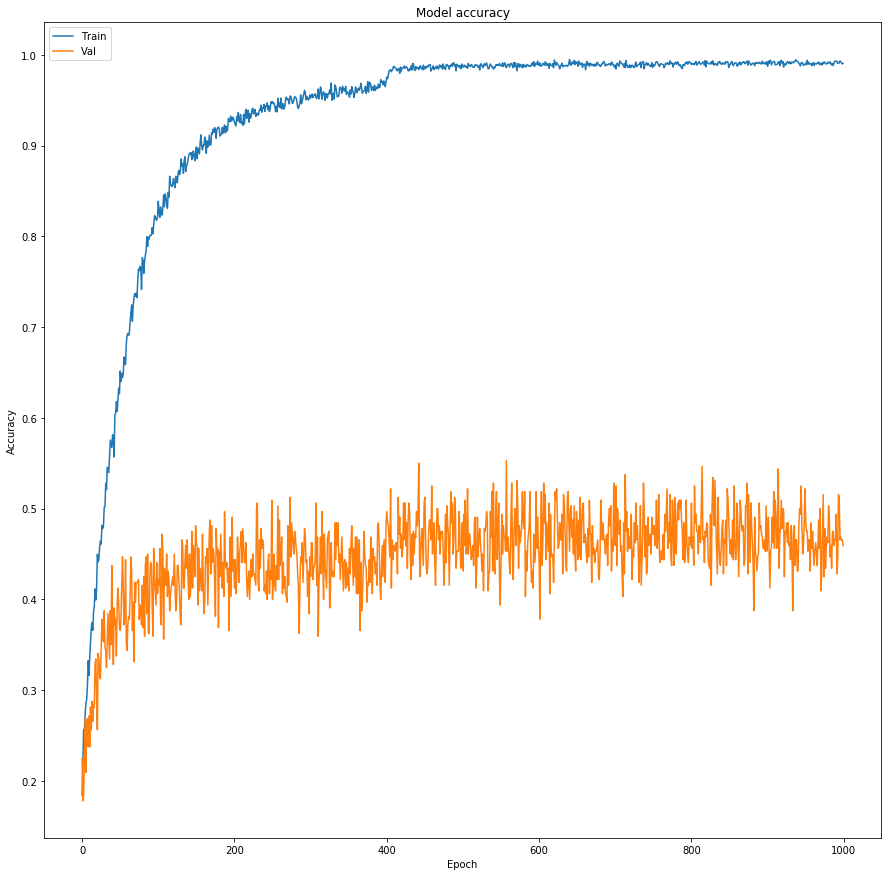

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize = (15,15))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

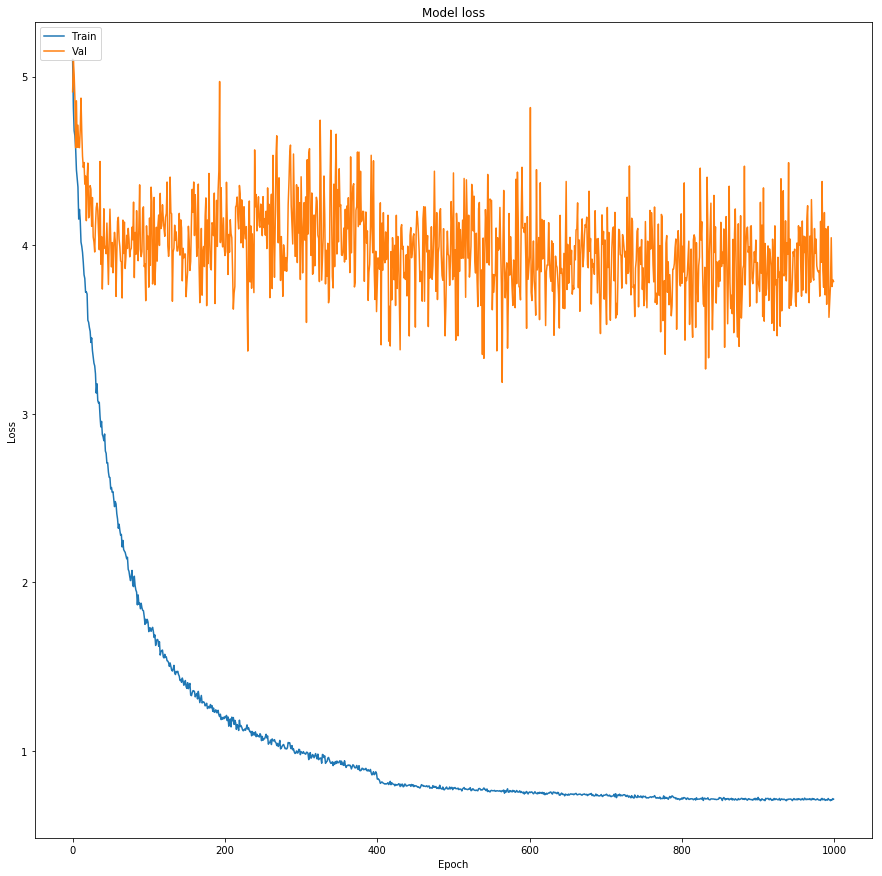

In [14]:
# Plot training & validation loss values
plt.figure(figsize = (15,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [15]:
scores = model.evaluate_generator(generator=testing_batches,verbose=1,steps=testing_batches2.samples//batch_size)
print(scores)


16904/16904 [==============================] - 1422s 84ms/step
[3.883246474690873, 0.46692350922858494, 0.7175002957879791]
